# Part 3: Single-View Geometry

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [19]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Provided functions

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    plt.show()
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.show()

In [4]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

# Your implementation

In [5]:
def get_vanishing_point(lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    inter1 = np.cross(lines[:, 0], lines[:, 1])
    inter2 = np.cross(lines[:, 0], lines[:, 2])
    inter3 = np.cross(lines[:, 1], lines[:, 2])
    inter1_homo = inter1 / inter1[-1]
    inter2_homo = inter2 / inter2[-1]
    inter3_homo = inter3 / inter3[-1]
    inter = np.vstack([inter1_homo, inter2_homo, inter3_homo])
    vp = np.mean(inter, axis=0)
    return vp


In [44]:
def get_horizon_line(vps):
    """
    Calculates the ground horizon line.
    """
    vpx, vpy = vps[:, 0], vps[:, 1]
    a, b ,c  = np.cross(vpx, vpy)
    scale = 1 / np.sqrt(a**2+b**2)
    lines = np.array([a, b, c]) * scale
    print("horizontal line params: ", lines)
    return lines


In [7]:
def plot_horizon_line(img, vps, color):
    """
    Plots the horizon line.
    """
    plt.figure()
    plt.imshow(img)
    vpx, vpy = vps[:, 0], vps[:, 1]
    plt.plot([vpx[0], vpy[0]], [vpx[1], vpy[1]], color)
    plt.show()
    return 
    

In [8]:
import sympy as sp

def get_camera_parameters(vps):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    v1 = sp.Matrix(vps[:, 0])
    v2 = sp.Matrix(vps[:, 1])
    v3 = sp.Matrix(vps[:, 2])
    f, px, py = sp.symbols('f px py')
    K = sp.Matrix(((f, 0, px), (0, f, py), (0, 0, 1)))
    K_inv = K.inv()
    cons1 = v1.T * K_inv.T * K_inv * v2
    cons2 = v1.T * K_inv.T * K_inv * v3
    cons3 = v2.T * K_inv.T * K_inv * v3
    sol = sp.solve([cons1, cons2, cons3], [f, px, py])
    f, px, py = sol[0]
    K = np.array([[f, 0, px], [0, f, py], [0, 0, 1]]).astype(np.float)
    print("Camera calib matrix: ", K)
    return f, px, py, K



In [9]:
def get_rotation_matrix(vps, K):
    """
    Computes the rotation matrix using the camera parameters.
    """
    vx, vy, vz = vps[:, 0], vps[:, 1], vps[:, 2]
    K_inv = np.linalg.inv(K)
    r1 = K_inv.dot(vx)
    r2 = K_inv.dot(vy)
    r3 = K_inv.dot(vz)
    R1 = r1 / np.linalg.norm(r1)
    R2 = r2 / np.linalg.norm(r2)
    R3 = r3 / np.linalg.norm(r3)
    R = np.vstack([R1, R2, R3]).T
    return R


In [10]:
def estimate_height(obj_coord, ref_coord, vps, ref_h):
    """
    Estimates height for a specific object using the recorded coordinates. You might need to plot additional images here for
    your report.
    """
    vx, vy, vz = vps[:, 0], vps[:, 1], vps[:, 2]
    r, b = obj_coord[:, 0], obj_coord[:, 1]
    t0, b0 = ref_coord[:, 0], ref_coord[:, 1]
    v = np.cross(np.cross(b, b0), np.cross(vx, vy))
    t = np.cross(np.cross(v, t0), np.cross(r, b))
    t = t / t[-1]
    ratio = np.linalg.norm(t-b) * np.linalg.norm(vz-r) / (np.linalg.norm(r-b) * np.linalg.norm(vz-t)) 
    obj_h = ref_h / ratio
    return obj_h 

    

# Main function

In [45]:
im = np.asarray(Image.open('CSL.jpeg'))

# Part 1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
# for i in range(num_vpts):
#     print('Getting vanishing point %d' % i)
#     # Get at least three lines from user input
#     n, lines, centers = get_input_lines(im)
#     vpts[:, i] = get_vanishing_point(lines)
#     # Plot the lines and the vanishing point
#     plot_lines_and_vp(im, lines, vpts[:, i])

vpts = np.array([[-3.21387197e2,  1.34317946e3,  5.41450444e2],
 [ 2.18547020e2,  2.30503363e2,  7.68057890e3],
 [ 1.00000000,  1.00000000,  1.00000000]])
print("vanishing pt: ", vpts)

horizon_line = get_horizon_line(vpts)
plot_horizon_line(im, vpts, color="g")

# Part 2
f, u, v, K = get_camera_parameters(vpts)

# Part 3
R = get_rotation_matrix(vpts, K)
print("ratation matrix: ", R)

# Part 4
# Record image coordinates for each object and store in map
objects = ('person', 'CSL building', 'the spike statue', 'the lamp posts')
coords = dict()
# for obj in objects:
#     coords[obj] = get_top_and_bottom_coordinates(im, obj)
coords = {'person': np.array([[627.11290323, 627.11290323],
       [469.17419355, 512.52903226],
       [  1.        ,   1.        ]]), 'CSL building': np.array([[540.40322581, 540.40322581],
       [ 66.59354839, 306.07741935],
       [  1.        ,   1.        ]]), 'the spike statue': np.array([[602.33870968, 602.33870968],
       [194.59354839, 475.36774194],
       [  1.        ,   1.        ]]), 'the lamp posts': np.array([[684.91935484, 678.72580645],
       [493.9483871 , 681.81935484],
       [  1.        ,   1.        ]])}
print(coords)
# <YOUR IMPLEMENTATION> Estimate heights
ref_h = 1.6764   
print("")
print("Person height: {:.2f} m".format(ref_h))
for obj in objects[1:]:
    height = estimate_height(coords[obj], coords['person'], vpts, ref_h)
    print('Estimating height of {} is {}'.format(obj, height))


vanishing pt:  [[-3.21387197e+02  1.34317946e+03  5.41450444e+02]
 [ 2.18547020e+02  2.30503363e+02  7.68057890e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00]]
horizontal line params:  [-7.18267095e-03  9.99974204e-01 -2.20849801e+02]
Camera calib matrix:  [[-822.92138174    0.          594.34131321]
 [   0.         -822.92138174  317.09180841]
 [   0.            0.            1.        ]]
ratation matrix:  [[ 0.74142118 -0.671002    0.00713823]
 [ 0.07978696  0.07758822 -0.99378776]
 [ 0.66627973  0.73738483  0.11106276]]
{'person': array([[627.11290323, 627.11290323],
       [469.17419355, 512.52903226],
       [  1.        ,   1.        ]]), 'CSL building': array([[540.40322581, 540.40322581],
       [ 66.59354839, 306.07741935],
       [  1.        ,   1.        ]]), 'the spike statue': array([[602.33870968, 602.33870968],
       [194.59354839, 475.36774194],
       [  1.        ,   1.        ]]), 'the lamp posts': array([[684.91935484, 678.72580645],
       [493.9483871 ,

In [17]:
ref_h = 1.8288  
print("Person height: {:.2f} m".format(ref_h))
for obj in objects[1:]:
    height = estimate_height(coords[obj], coords['person'], vpts, ref_h)
    print('Estimating height of {} is {}'.format(obj, height))

Person height: 1.83 m
Estimating height of CSL building is 34.60032058861511
Estimating height of the spike statue is 13.153168918267516
Estimating height of the lamp posts is 5.353358939925721


In [13]:
def draw_measurement_line(img, person_coord, obj_coord, vps):
    vx = vps[:, 0]
    vy = vps[:, 1]
    vz = vps[:, 2]

    plt.figure()
    plt.imshow(im)
    
    r, b = obj_coord[:, 0], obj_coord[:, 1]
    t0, b0 = person_coord[:, 0], person_coord[:, 1]
    v = np.cross(np.cross(b, b0), np.cross(vx, vy))
    t = np.cross(np.cross(v, t0), np.cross(r, b))
    v = v / v[-1]
    t = t / t[-1]
    
    # draw line
    vx = vx / vx[-1]
    vy = vy / vy[-1]
    vz = vz / vz[-1]
    if t0[0] > t[0]:
        top = t0
        bot = b0
    else:
        top = t
        bot = b
    plt.plot([v[0], top[0]], [v[1], top[1]], 'g')
    plt.plot([v[0], bot[0]], [v[1], bot[1]], 'g')
    plt.plot([vx[0], vy[0]], [vx[1], vy[1]], 'b')
    plt.plot([r[0], b[0]], [r[1], b[1]], 'b')
    plt.plot([t0[0], b0[0]], [t0[1], b0[1]], 'b')
    # draw point
    plt.plot(vx[0], vx[1], 'ro')
    plt.text(vx[0]+10, vx[1], "Vx")
    plt.plot(vy[0], vy[1], 'ro')
    plt.text(vy[0]+10, vy[1], "Vy")
    plt.plot(v[0], v[1], 'ro')
    plt.text(v[0]+10, v[1]+10, "V")
    plt.plot(t[0], t[1], 'ro')
    plt.text(t[0]+10, t[1], "t")
    plt.plot(b[0], b[1], 'ro')
    plt.text(b[0]+10, b[1], "b")
    plt.plot(r[0], r[1], 'ro')
    plt.text(r[0]+10, r[1], "r")
    plt.plot(t0[0], t0[1], 'ro')
    plt.text(t0[0]+10, t0[1], "t0")
    plt.plot(b0[0], b0[1], 'ro')
    plt.text(b0[0]+10, b0[1], "b0")
    plt.show()

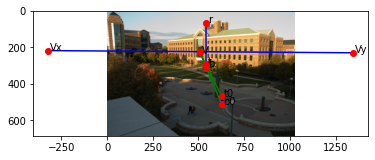

In [14]:
draw_measurement_line(im, coords["person"], coords["CSL building"], vpts)

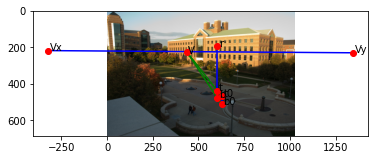

In [15]:
draw_measurement_line(im, coords["person"], coords["the spike statue"], vpts)

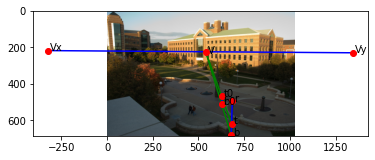

In [16]:
draw_measurement_line(im, coords["person"], coords["the lamp posts"], vpts)

In [48]:
# extra 
extra_objects = ('person2', 'person3', 'person4')
# coords_extra = dict()
# for obj in extra_objects:
#     coords_extra[obj] = get_top_and_bottom_coordinates(im, obj)

coords_extra = {'person2': np.array([[451.62903226, 453.69354839],
       [510.78709677, 568.27096774],
       [  1.        ,   1.        ]]), 
       'person3': np.array([[472.27419355, 470.20967742],
       [508.91612903, 562.07741935],
       [  1.        ,   1.        ]]), 
       'person4': np.array([[321.56451613, 317.43548387],
       [373.27096774, 401.04516129],
       [  1.        ,   1.        ]]),} 
# plot person
plt.imshow(im)
plt.plot(452, 540, "ro")
plt.text(452-10, 540, "1")
plt.plot(470, 535, "ro")
plt.text(470+10, 535, "2")
plt.plot(320, 387, "ro")
plt.text(320+10, 387, "3")
plt.show()

print(coords_extra)
# Estimate heights: reference height (of the person) in cm: 167.64 / 182.88
ref_h = 1.6764
print("Person height: {:.2f} m".format(ref_h))
for obj in extra_objects:
    height = estimate_height(coords_extra[obj], coords['person'], vpts, ref_h)
    print('Estimating height of {} is {}'.format(obj, height))

{'person2': array([[451.62903226, 453.69354839],
       [510.78709677, 568.27096774],
       [  1.        ,   1.        ]]), 'person3': array([[472.27419355, 470.20967742],
       [508.91612903, 562.07741935],
       [  1.        ,   1.        ]]), 'person4': array([[321.56451613, 317.43548387],
       [373.27096774, 401.04516129],
       [  1.        ,   1.        ]])}
Person height: 1.68 m
Estimating height of person2 is 1.871204787252314
Estimating height of person3 is 1.7287456889574149
Estimating height of person4 is 1.8120171793793394
